# Hypothesis testing for the difference between two binomials distributions

Hypothesis testing for a [binomial proportion](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval) is a well-studied problem. Most statistical libraries contain [multiple methods](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportion_confint.html) of generating confidence intervals (CIs) for a binomial proportion. Testing the *difference* between two binomial proportions is a similar statistical problem, although the range of available methods is more limited. In my experience, most statistical handbooks recommend using normal approximations or contingency tables when there are two sets of binary outcomes to be compared. Unfortunately these approaches have drawbacks. Normal approximations based on asymptotic theory have to noticeably poor coverage when sample sizes are small or the probability of an event is close to zero or one. Though Fisher's Exact test is useful for obtaining p-values under the null, it does not allow for the calculation of CIs, it is hard to use for power calculations, and require approximations when the outcome space is large. The idea of using an *exact* distribution of the difference in two binomial proportions is not a new one (see [here](https://www.jstor.org/stable/2533740?seq=1) or [here](https://arxiv.org/pdf/1903.03327.pdf)). "Exact" refers to using actual quintiles of the test statistic's distribution, rather than approximations. However exact CIs for the difference between binomial distributions are almost never used, and, as far as I know, not supported in languages like `python`. 

In this post I want to provide researchers with the tools necessary to carry out hypothesis testing for the difference between two binomial distributions. I will also highlight the main statistical challenge inherant in the inference of the problem: when the null proportion is not known before the sampling. By the end of the post, I will provide:  

1. Functions to calculate the PMF and CDF for the distribution of a difference between binomials
2. Functions to generate CIs for this distribution at any nominal level
3. A proof that the empirical CIs are unknowably conservative when the null proportion needs to be estimated.

Note that if the null proportion is known before testing, then the type-I errors will be conservative, but *knowably* so, since the difference between the targeted and actual levels will be determined by the discrete nature of the CDF. However, when the null proportion itself needs to be estimated, I will show that CIs will be more conservative than what is suggested by the CDF derived from the empirical null proportion. 

## (1) Review: Exact CIs for a single binomial distribution

This first section will review the binomial distribution, establish notation, and show has exact and knowably-conservative CIs can be constructed for hypothesis testing. The binomial distribution, $y \sim B(n,\pi)$, is parameterized by the number of trials ($n$) and the probability of a positive outcome ($\pi$), where $E(y)=\pi$. As there are many ways to have $k$ successes, the PMF of this discrete distribution uses the [binomial coefficient](https://en.wikipedia.org/wiki/Binomial_coefficient) to capture these *combinations*:

$$
\begin{align*}
f_{\pi,n}(k) &= P(y = k) = \begin{pmatrix} n \\ k \end{pmatrix} \pi^k (1-\pi)^{1-k} \\
F_{\pi,n}(k) &= P(y \leq k) = \sum_{j=0}^k f_{\pi,n}(j)
\end{align*}
$$

The binomial distribution can represent a number of useful processes we may want to carry out inference on such as the frequency of credit defaults, the sensitivity of a test, or the precision of a classier. All of these processes  count the number of times a binary event happens out of a total number of trials. Hypothesis testing for a binomial random variable is therefore to reject (or not) some claim about the underlying proportion $\pi$, since this is the parameter that defines the distribution. For example if we wanted to test whether a medical test had a sensitivity of greater than 90% we would want to reject the following null:

$$
\begin{align*}
H_0:& \pi \leq 0.9 \\
H_A:& \pi > 0.9
\end{align*}
$$

The test statistic $\hat\pi=y/n$ is the obvious choice to estimate this quantity since it is the  minimum-variance unbiased estimator. A confidence interval is defined by a tuple $I_\alpha = [l,u]$, $l\leq u$, which is itself a statistic (i.e. random variable), that should have the following coverage property:[[^1]]

$$
\begin{align*}
P(\pi \in [l, u]| H_0) \geq 1-\alpha \hspace{1mm},
\end{align*}
$$

Where $\alpha$ is the type-I error rate. In other words, the probability that the parameter of interest falls outside this interval occurs *at most* $\alpha$% of the time. This need to be conservative requires the choice of quantile to be similar conservative with respect to the CDF. For example, consider the distribution of 20 fair coin flips where the probability that 13 or fewer heads will occur is 94%, whereas 14 or fewer heads occuring is 98%. If one needed to pick an upper bound so that the number of times the null of $\pi\leq 0.5$ was rejected was *at most* 5%, then one would have to the interval $[0,14]$, even though the type-I error rate would actually only be 2% rather than the desired 5%.  

$$
\begin{align}
k_{\alpha}^* &= F_{\pi,n}^{-1}(\alpha) = \begin{cases} \inf_k \hspace{2mm} \{ k: F(k) \geq \alpha \} &\text{if}& \alpha \geq 0.5  \\ 1+\sup_k \{ k: F(k) \leq \alpha \} &\text{if}& \alpha < 0.5  \end{cases} \label{eq:thresh_binom}
\end{align}
$$

Equation \eqref{eq:thresh_binom} shows how to conservatively invert the CDF if the binomial distribution so that intervals formed by $[k_{\alpha}^*, k_{1-\alpha}^*]$ obtain a coverage of at least $1-2\alpha$. But since the test statistic is $y/n$ and not $y$, it is easy enough to see how the upper and lower CIs are to be constructed:

$$
\begin{align*}
l& = \hat\pi- (n^{-1}\cdot k_{1-\alpha/2}^* -\pi), \\
u& = \hat\pi+(\pi-n^{-1}\cdot k_{\alpha/2}^*),
\end{align*}
$$

Where $\pi$ is the proportion on the null. Notice that we are using the upper quantile to define the lower bound and vice versa. In the case of the well-known normal quantile, these terms are symmetric so it is ignored. However, if there is an asymetry beween the mean ($\pi$) and upper quantiles of the distribution, then we want this value to be subtracted off (hence why it is in the lower bound). Deriving the type-I error from these bounds is simply to do and reveals why $k_{1-\alpha/2}^{*}$ needs to be in the lower bound.

$$
\begin{align*}
P(\pi < l ) &= P\big(\pi < \hat\pi- (n^{-1}\cdot k_{1-\alpha/2}^* -\pi) \big) \\
&= P\big(n\pi < n\hat\pi- k_{1-\alpha/2}^* +n\pi \big)  \\
&= P\big(y > k_{1-\alpha/2}^*) \\
&\leq \alpha/2
\end{align*}
$$



The first code block below defines the function `qbinom` which implements \eqref{eq:thresh_binom} and shows that these exact confidence intervals get a knowably conservative coverage region for a 90% confidence interval.

[^1]: This definition of a confidence interval has been in use since Jerzy Neyman's definition of it in a classic 1937 [paper](https://royalsocietypublishing.org/doi/pdf/10.1098/rsta.1937.0005).

In [189]:
import numpy as np
import pandas as pd
import plotnine
from plotnine import *
from scipy.stats import norm, binom

# Function to calculate t*_alpha
def qbinom(alpha, n, pi):
    assert (alpha >= 0) & (alpha <= 1)
    kstar = int(stats.binom.ppf(q=alpha,n=n,p=pi)) # Use first quantile estimate
    Fk = binom.cdf(k=kstar,n=n,p=pi) # Calculate p-value
    check = bool(np.where(alpha>0.5, Fk>=alpha, Fk<=alpha))
    while not check:
        kstar = int(np.where(alpha>0.5, kstar+1, kstar-1))
        Fk = binom.cdf(k=kstar,n=n,p=pi)
        check = bool(np.where(alpha>0.5, Fk>=alpha, Fk<=alpha))
    kstar = int(np.where(alpha>0.5, kstar, kstar+1))
    return kstar


np.random.seed(1234)
nsim = 250000
alpha = 0.1
pi_seq = np.round(np.arange(0.01,1,0.01),2)
n_seq = 2**np.arange(3,8,1)
decimals = 12 # Getting float point issues otherwise

holder = []
for pi in pi_seq:
    for n in n_seq:
        # Establish the lower/upper quantile bounds
        ku = qbinom(alpha=1-alpha/2, n=n, pi=pi)
        kl = qbinom(alpha=alpha/2, n=n, pi=pi)
        # Draw data under the null
        khat = np.random.binomial(n, pi, size=nsim)
        phat = khat / n
        # Calculate the CIs under the null
        l = phat - (ku/n - pi)
        u = phat + (pi-kl/n)
        coverage = np.mean((pi >= np.round(l,decimals)) & (pi <= np.round(u,decimals)))
        # Calculate the expected coverage
        t1_u = 1-binom.cdf(k=ku,n=n,p=pi)
        t1_l = binom.cdf(k=kl-1,n=n,p=pi)
        t1e = t1_u + t1_l
        tmp = pd.DataFrame({'pi':pi,'n':n,'coverage':coverage,'expected':t1e},index=[0])
        holder.append(tmp)
sim_exact = pd.concat(holder).reset_index(None,True).assign(n=lambda x: pd.Categorical(x.n, x.n.unique()),actual=lambda x: 1-x.coverage)


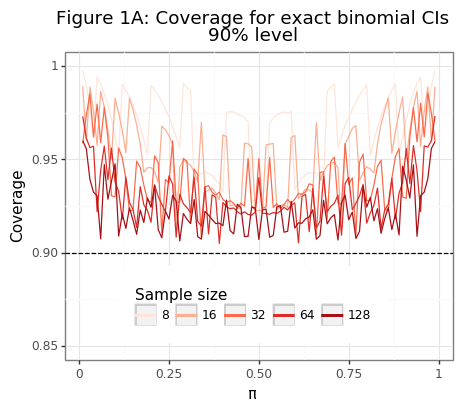

<ggplot: (8733218695785)>


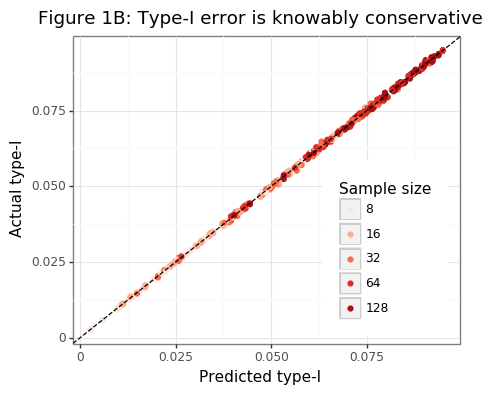

<ggplot: (8733218959333)>


In [203]:
plotnine.options.figure_size = (5, 4)
gg_cov_exact = (ggplot(sim_exact, aes(x='pi',y='coverage',color='n'))+
               theme_bw() + geom_line() + 
               labs(x='π',y='Coverage') + 
               ggtitle('Figure 1A: Coverage for exact binomial CIs\n90% level') + 
               theme(legend_position=(0.5,0.25),legend_direction='horizontal') + 
               scale_y_continuous(limits=[0.85,1.0],breaks=list(np.arange(0.85,1.01,0.05))) + 
               geom_hline(yintercept=0.90,linetype='--') + 
               scale_color_brewer(name='Sample size', palette='Reds'))
print(gg_cov_exact)

plotnine.options.figure_size = (5, 4)
gg_t1_exp = (ggplot(sim_exact, aes(x='expected',y='actual',color='n'))+
               theme_bw() + geom_point() + 
               labs(x='Predicted type-I',y='Actual type-I') + 
               ggtitle('Figure 1B: Type-I error is knowably conservative') + 
               scale_color_brewer(name='Sample size', palette='Reds') + 
             geom_abline(slope=1,intercept=0,linetype='--') + 
             theme(legend_position=(0.75,0.35)))
print(gg_t1_exp)

Figure 1A demonstrates how we can obtain a conservative coverage region for the binomial distribution. Keep in mind that in the case where $\pi$ is close to 0 or 1, and $n$ is small, the coverage region may amount to 100% for the 90% level! Though we have not yet even discussed power calculations for these exact CIs, it is clear that no sample size will be sufficient to reject the null in this case. For example if $n=8$ and $\pi=0.7$, then $F(7)=0.94$ and $F(8)=1.0$, so the coverage region amounts to $\hat p \leq 1$! In summary, though "exact" confidence intervals will not be able to obtain exact coverage due to their discrete nature. Figure 1B shows this the type-I conservative can be knowable predicted. This allows for the probably calculation of power under some alternative $\pi$.

## (2) Difference in binomials

$p_i = y_i / n$ and $y_i \sim \text{Binom}(n,\pi_i)$ comes from a binomial distribution then the CIs do not need to be based on *approximations* because they can be calculated using the exact quantiles. However this approach is used less often than would normally be expected for two reasons. First, because the binomial distribution is discrete, the CDF may have large jumps. 

The second issue with using exact CIs for two proportions from a binomial distribution is that we need to develop a custom CDF and its quantile for $\delta=y_1 - y_2$. 

$$
\begin{align*}
s(d;\mathbf{n}, \mathbf{\pi}) &= \{ f_{Y_1}(k_1;n_1,\pi_1) \cdot f_{Y_2}(k_2;n_2,\pi_2) \hspace{1mm} | \hspace{1mm} k_1-k_2=d \} \\
f_\delta(d; \mathbf{n}, \mathbf{\pi}) &= \sum_{ s_i \in s(d)} s_i \\
F_\delta(d; \mathbf{n}, \mathbf{\pi}) &= P(K_1 - K_2 \leq d) \\
&= \sum_{j=-n_2}^d f_\delta(j; \mathbf{n}, \mathbf{\pi})
\end{align*}
$$

The first term, $s(d)$, captures the set of all outcomes where the difference between $y_1$ and $y_2$ is exactly $d$. Because $y_1$ and $y_2$ are independent, the PMF of $\delta$  ($f_\delta$) simply the sum of the product of probabilities seen in $s(d)$. Lastly, the CDF, $F_\delta$, answers the question: what is the probability of observing a difference in these two binomial distributions of *$d$ or less*. Computationally, it is easiest to calculate the PMF/CDF as a matrix and then group by all the values from $[-n_2,\dots,n_1]$ as this represents the smallest and largest observable value (although in practice their respectively probabilities may be basically zero). The `binom_diff` class below calculates the PMF and CDF defined above. A simple simulation also shows that the empirical CDF lines up with our theoretical expectation.

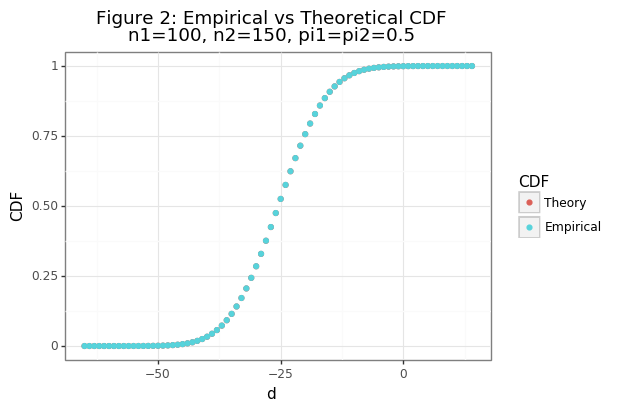

<ggplot: (8733227432909)>

In [4]:
class binom_diff():
    def __init__(self, n1, pi1, n2, pi2):
        check1 = (n1 >= 0) & (n2 >= 0) & (isinstance(n1,int)) & (isinstance(n1,int))
        check2 = (pi1 >= 0) & (pi1 <= 0) & (pi2 >= 0) & (pi2 <= 0)
        y1seq, y2seq = np.meshgrid(range(n1+1), range(n2+1)) # create the actual grid
        y1seq, y2seq = y1seq.flatten(), y2seq.flatten()
        s_d = stats.binom.pmf(y1seq, n1, pi1) * stats.binom.pmf(y2seq, n2, pi2)
        self.df = pd.DataFrame({'d':y1seq-y2seq,'pdf':s_d}).groupby('d').pdf.sum().reset_index()
        assert np.abs(self.df.pdf.sum() - 1) < 1e-6
        self.df['cdf'] = self.df.pdf.cumsum()
    def cdf(self, d):
        return self.df.query('d == @d').cdf.values[0]
    def qdf(self, p):
        assert (p >= 0) & (p <= 1)
        if p > 0.5:
            dstar = dist.df.query('cdf >= @p').head(1).d.values[0]
        elif p < 0.5:
            dstar = self.df.query('cdf <= @p').tail(1).d.values[0]
        else:
            dstar = int(self.df.loc[np.argmin((self.df.cdf-0.5)**2)]['d'])
        return dstar
    
# Check that the QQ-plots line up
np.random.seed(1234)
nsim = 10000000
n1, n2 = 100, 150
pi1, pi2 = 0.5, 0.5
res = pd.Series(np.random.binomial(n1,pi1,nsim) - np.random.binomial(n2,pi2,nsim)).value_counts(True).reset_index()
res = res.rename(columns={'index':'n',0:'p'}).sort_values('n').reset_index(None,True)
dist_dbinom = binom_diff(n1, pi1, n2, pi2)
df_comp = res.assign(ecdf=lambda x: x.p.cumsum()).drop(columns='p')
df_comp = df_comp.merge(dist_dbinom.df,'left',left_on='n',right_on='d').drop(columns='pdf')
df_comp = df_comp.melt('d',['cdf','ecdf'],'tt')

title5 = 'Figure 2: Empirical vs Theoretical CDF\nn1=100, n2=150, pi1=pi2=0.5'
plotnine.options.figure_size = (5.5, 4)
gg_cdf_check = (ggplot(df_comp, aes(x='d',y='value',color='tt')) + theme_bw() + 
                geom_point() + labs(y='CDF',x='d') + ggtitle(title5) + 
                scale_color_discrete(name='CDF',labels=['Theory','Empirical']))
gg_cdf_check

Figure 2 shows that the grid approach to calculate the PMF works. Next we want to ensure that the quantiles produced by `binom_dist` create a rejection region that obtains at most a $1-\alpha$ type-I error rate. You may notice that I'm adding 1 to the lower bound critical value but not the upper bound. The reason for this is simple, but a bit technical. I'm defining a two-sided coverage region as $\hat l \leq \hat \delta \leq \hat u$. Consider the case when $F_\delta(-63)=0.038$ when $n_1=50$, $n_2=150$, and $\pi=0.5$. Then $P(K_1-K_2>-63)=P(K_1-K_2\geq -62)=0.962$. In other words we want to add plus one to the lower bound in the sense that we will define the *rejection region* as $\hat \delta < \hat l$ (with emphasis on the strictly less than). In contrast since $F_\delta(-38)=0.962$, then $P(K_1-K_2 \leq -38)=0.962$ so that $\hat \delta > \hat u$ will be sufficient for the rejection criterion and no modification needs to be made.

In [ ]:
if 'df_res.csv' in os.listdir():
    df_res = pd.read_csv('df_res.csv')
else:
    np.random.seed(seed)
    nsim = 5000
    alpha = 0.10
    pi_seq = [0.5] # np.round(np.arange(0.1,1,0.1),2)
    n1_seq = [50] # [50, 100, 150]
    n2_seq = [150] # n1_seq
    nperm = len(pi_seq)*len(n1_seq)*len(n2_seq)
    holder = []
    count = 0
    for pi in pi_seq:
        for n1 in n1_seq:
            for n2 in n2_seq:
                n_tot = (n1+n2)
                y1 = np.random.binomial(n1, pi, nsim)
                y2 = np.random.binomial(n2, pi, nsim)
                pi_hat = (y1+y2)/n_tot
                delta_hat = (y1 - y2)
                type1 = np.zeros([nsim, 2])
                bounds = type1.copy().astype(int)
                stime = time()
                for ii in range(nsim):
                    dist_ii = binom_diff(pi1=pi_hat[ii],n1=n1,pi2=pi_hat[ii],n2=n2)
                    lb_ii, ub_ii = (dist_ii.qdf(alpha/2), dist_ii.qdf(1-alpha/2))
                    type1[ii] = [dist_ii.cdf(lb_ii), 1-dist_ii.cdf(ub_ii)]
                    lb_ii += 1  # see explaination above for this
                    bounds[ii] = [lb_ii, ub_ii]
                cov_lb = np.mean(delta_hat >= bounds[:,0])
                cov_ub = np.mean(delta_hat <= bounds[:,1])
                err_lb, err_ub = np.mean(type1[:,0]), np.mean(type1[:,1])
                tmp = pd.DataFrame({'cov_lb':cov_lb, 'cov_ub':cov_ub,
                                    'err_lb':err_lb, 'err_ub':err_ub,
                                    'n1':n1, 'n2':n2, 'pi':pi},index=[0])
                print(tmp)
                holder.append(tmp)
                count += 1
                nleft, nsec = nperm - count, time() - stime
                print('pi: %0.2f, n1=%i, n2=%i, took %i seconds (%i of %i)' % (pi, n1, n2, nsec, count, nperm))
    df_res = pd.concat(holder).reset_index(None,True)
    #df_res.to_csv('df_res.csv',index=False)
# df_res = df_res.assign(t1_lb=lambda x: 1-x.cov_lb, t1_ub=lambda x: 1-x.cov_ub)
# df_res = df_res.assign(type1=lambda x: x.t1_lb+x.t1_ub, etype1=lambda x: x.err_lb+x.err_ub)
# df_res_long = df_res.melt(['n1','n2','pi'],['type1','etype1'],'tt')

# plotnine.options.figure_size = (7, 6.5)
# gg_cov_delta = (ggplot(df_res_long,aes(x='pi',y='value',color='tt')) + theme_bw() + 
#                 geom_point() + facet_wrap('~n1+n2',ncol=3,labeller=label_both) + 
#                 geom_hline(yintercept=0.1,color='black') + labs(x='π',y='Type-I error') + 
#                 ggtitle('Figure 3: Type-I error rates for 90% CI') + 
#                 scale_x_continuous(breaks=list(np.sort(df_res_long.pi.unique()))) + 
#                 scale_y_continuous(limits=[0,0.12],breaks=list(np.arange(0,0.14,0.02))) + 
#                 theme(panel_grid_minor=element_blank()) + 
#                 scale_color_discrete(name='Type-I',labels=['Expected','Actual']))
# gg_cov_delta

Figure 3 shows that when $n_1=n_2$, then the expected type-I error rate lines up with the actual one. First let me explain how the expected type-I error rate was calculated. Recall the previous example where $F_\delta(-63)=0.038$ and $F_\delta(-38)=0.962$, then setting the non-rejection region as $-62 \leq \delta \leq -38$ will get an actual type-I error rate of $0.038+(1-0.962)=0.0762$, which though smaller than the 10% level we are targetting, is at least knowable. However, in practice we don't know the true distribution of $F_\delta$ because we have to estimated $\pi$ (only $n_1+n_2$ is known).

In [ ]:
np.random.seed(seed)
alpha = 0.10
n1, n2, pi = 150, 150, 0.5
nsim, n_tot = 5000, n1+n2
y1 = np.random.binomial(n1, pi, nsim)
y2 = np.random.binomial(n2, pi, nsim)
dist_gt = binom_diff(pi1=pi,n1=n1,pi2=pi,n2=n2)
pi_hat = (y1+y2)/n_tot
delta_hat = (y1 - y2)
type1 = np.zeros([nsim, 2])
bounds = type1.copy().astype(int)
for ii in range(nsim):
    dist_ii = binom_diff(pi1=pi_hat[ii],n1=n1,pi2=pi_hat[ii],n2=n2)
    lb_ii, ub_ii = (dist_ii.qdf(alpha/2), dist_ii.qdf(1-alpha/2))
    type1[ii] = [dist_ii.cdf(lb_ii), 1-dist_ii.cdf(ub_ii)]
    lb_ii += 1
    bounds[ii] = [lb_ii, ub_ii]
    
print(type1.mean(0))
print((np.mean(delta_hat < bounds[:,0]), np.mean(delta_hat > bounds[:,1])))

dist_ii = binom_diff(pi1=0.35,n1=n1,pi2=0.35,n2=n2)
(dist_ii.qdf(alpha/2), dist_ii.qdf(1-alpha/2))

lb_gt, ub_gt = (dist_gt.qdf(alpha/2), dist_gt.qdf(1-alpha/2))
t1_lb_gt, t1_ub_gt = (dist_gt.cdf(lb_gt), 1-dist_gt.cdf(ub_gt))
lb_gt += 1
dat_bounds_gt = pd.DataFrame({'bound':['lb','ub'], 'gt':[lb_gt, ub_gt],'pval':[t1_lb_gt,t1_ub_gt]})
dat_bounds = pd.DataFrame(bounds,columns=['lb','ub']).assign(phat=pi_hat,idx=range(len(pi_hat)))
dat_bounds = dat_bounds.melt(['idx','phat'],None,'bound')
dat_cov = pd.DataFrame({'lb':delta_hat < bounds[:,0], 'ub':delta_hat > bounds[:,1],'pi':pi_hat})
dat_cov['qq'] = pd.cut(dat_cov.pi,[0]+dat_cov.pi.quantile(np.arange(0.2,1.01,0.2)).to_list())
print(dat_cov.groupby('qq')[['lb','ub']].mean().sum(1))

# Expected type-I by pi_hat
dat_et1 = pd.DataFrame({'t1':type1.sum(1),'phat':pi_hat})
plotnine.options.figure_size = (5,4)
(ggplot(dat_et1, aes(x='phat',y='t1')) + theme_bw() + geom_point())

plotnine.options.figure_size = (7,3.5)
gg_tmp = (ggplot(dat_bounds,aes(y='phat',x='value',color='bound')) + theme_bw() + 
          facet_wrap('~bound',scales='free_x') + geom_point() + 
         theme(subplots_adjust={'wspace': 0.1}) + 
         geom_vline(aes(xintercept='gt'),data=dat_bounds_gt))
gg_tmp

(ggplot(pd.DataFrame({'d':delta_hat,'pi':pi_hat}), aes(x='pi',y='d')) + geom_point() + 
 theme_bw())